This codebook looks at the temperatures in the cluster 1 identified in the nenana_river codebook.  This first cell loads in the temperature data from 01/01/1992 to 03/27/2022.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import re

tdf_1 = pd.read_csv('temp_1.csv')
tdf_2 = pd.read_csv('temp_2.csv')
tdf_3 = pd.read_csv('temp_3.csv')
tdf_4 = pd.read_csv('temp_4.csv')
tdf_5 = pd.read_csv('temp_5.csv')

sdf_1 = pd.read_csv('precip1.csv')
sdf_2 = pd.read_csv('precip2.csv')
sdf_3 = pd.read_csv('precip3.csv')
sdf_4 = pd.read_csv('precip4.csv')
sdf_5 = pd.read_csv('precip5.csv')

tdf = pd.concat([tdf_1, tdf_2, tdf_3, tdf_4, tdf_5])
sdf = pd.concat([sdf_1, sdf_2, sdf_3, sdf_4, sdf_5])

# sdf = pd.concat([sdf_1, sdf_2])

# tdf = pd.concat([tdf_1, tdf_2])
# tdf.drop(axis=1, columns='TOBS', inplace=True)

def get_year(value):
    if bool(re.match('^\d{4}', value[:4])):
        return value[:4]

def get_month(value):
    if bool(re.match('^\d{2}', value[5:7])):
        return value[5:7]

def get_day(value):
    if bool(re.match('^\d{2}', value[8:])):
        return value[8:]

tdf.drop(tdf[tdf['TMAX'] > 96.1].index, inplace=True)
tdf.drop(tdf[tdf['TMIN'] < -65.9].index, inplace=True)

tdf['year'] = tdf['DATE'].apply(lambda x: get_year(x))
tdf['month'] = tdf['DATE'].apply(lambda x: get_month(x))
tdf['day'] = tdf['DATE'].apply(lambda x: get_day(x))

sdf['year'] = sdf['DATE'].apply(lambda x: get_year(x))
sdf['month'] = sdf['DATE'].apply(lambda x: get_month(x))
sdf['day'] = sdf['DATE'].apply(lambda x: get_day(x))

tdf['DATE'] = pd.to_datetime(tdf['DATE'])
tdf['day of year'] = tdf['DATE'].dt.dayofyear
sdf['DATE'] = pd.to_datetime(sdf['DATE'])
sdf['day of year'] = sdf['DATE'].dt.dayofyear

tdf = tdf[tdf['NAME'] == 'FAIRBANKS INTERNATIONAL AIRPORT, AK US']
sdf = sdf[sdf['NAME'] == 'FAIRBANKS INTERNATIONAL AIRPORT, AK US']



Looking at the time series weather.  Some values were obviously wrong on min and max temps, these records were removed.  I am a bit perplexed at the mode is right at 32 for average temp.  

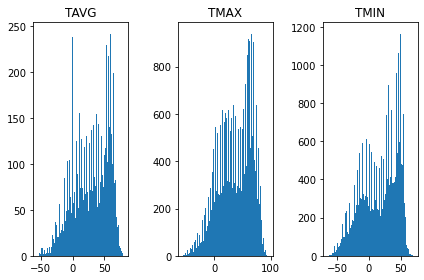

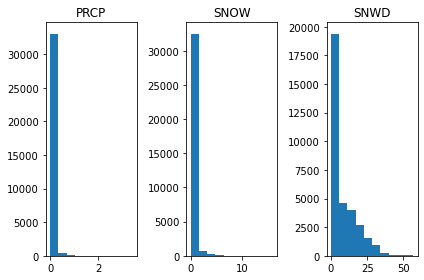

In [9]:
fig1, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.hist(tdf['TAVG'], bins=100)
ax1.set_title('TAVG')
ax2.hist(tdf['TMAX'], bins=100)
ax2.set_title('TMAX')
ax3.hist(tdf['TMIN'], bins=100)
ax3.set_title('TMIN')
fig1.tight_layout()

fig2, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.hist(sdf['PRCP'])
ax1.set_title('PRCP')
ax2.hist(sdf['SNOW'])
ax2.set_title('SNOW')
ax3.hist(sdf['SNWD'])
ax3.set_title('SNWD')
fig2.tight_layout()



So I think now I need to look at what variable may influence time of break up.  I suspect that snow depth and average temperature would have the biggest.  This cell will tie the cluster data frame (target) in the features frames.  Before this can be examined first a targets column needs to be created.  This is tricky because it is likely that information in the last calendar year influences breakup time in the next calendar year.  So my approach will be to just take all dates after a break to neaxt break ups features.  This is probably too simplistic and have unnecessary data perhaps I'll come back and tighten this up.  

In [36]:
cluster = pd.read_csv('cluster1.csv')
all_breakups = pd.read_csv('all_breakups.csv')
cluster.head()

def month_formatter(value):
    pass
    if value == 'April':
        return 4
    elif value == 'May':
        return 5

# cluster['Month'] = cluster['Month'].apply(lambda x: month_formatter(x))
# cluster['DATE'] = pd.to_datetime(cluster[['Year', 'Month', 'Day']])
# cluster.to_csv('cluster.csv')
# cluster.loc[cluster['Year'] == 1993]

all_breakups['Month'] = all_breakups['Month'].apply(lambda x: month_formatter(x))
all_breakups['DATE'] = pd.to_datetime(all_breakups[['Year', 'Month', 'Day']])
all_breakups.loc[all_breakups['Year'] == 1993]

merged_snowtemps = pd.merge(left=tdf, right=sdf[['DATE', 'PRCP', 'SNOW', 'SNWD']], how='left', on='DATE')
features_targets_df = pd.DataFrame()

previous_breakup = '1916-05-01'

# for breakup_date in cluster['DATE'].unique():
#     break_decimal = cluster['Decimal Day of Year'].loc[cluster['DATE'] == breakup_date]
#     mask = (merged_snowtemps['DATE'] > previous_breakup) & (merged_snowtemps['DATE'] <= breakup_date)
#     selection = merged_snowtemps.loc[mask] 
#     concat = pd.merge(left=selection, right=cluster[['DATE', 'Decimal Day of Year']], how='left', on='DATE')
#     features_targets_df = pd.concat([features_targets_df, concat])
#     features_targets_df['Decimal Day of Year'].fillna(float(break_decimal), inplace=True)
#     previous_breakup = breakup_date

for breakup_date in all_breakups['DATE'].unique():
    break_decimal = all_breakups['Decimal Day of Year'].loc[all_breakups['DATE'] == breakup_date]
    mask = (merged_snowtemps['DATE'] > previous_breakup) & (merged_snowtemps['DATE'] <= breakup_date)
    selection = merged_snowtemps.loc[mask] 
    concat = pd.merge(left=selection, right=all_breakups[['DATE', 'Decimal Day of Year']], how='left', on='DATE')
    features_targets_df = pd.concat([features_targets_df, concat])
    features_targets_df['Decimal Day of Year'].fillna(float(break_decimal), inplace=True)
    previous_breakup = breakup_date
    
    
predict_features = merged_snowtemps[merged_snowtemps['DATE'] > '2020-04-27']
features_targets_df.drop(labels=['TOBS', 'TAVG'], axis=1, inplace=True)
features_targets_df.to_csv('features_targets.csv')

print(len(features_targets_df))
predict_features.to_csv('predict_frame.csv')


37032


Now it is time to build the random forest model.  Unfortunately this is a pretty sparse dataset.  I am going to run this twice, once with all clusters and another time with just the last 30 year cluster.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

random_forest = RandomForestRegressor()
features_targets = features_targets_df.dropna(subset=['Decimal Day of Year', 'day of year', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD'])
print(features_targets.isna().sum())

targets_df = features_targets[['Decimal Day of Year']]
features_df = features_targets[['day of year', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']]
X_train, X_test, y_train, y_test = train_test_split(features_df, targets_df, test_size=0.2, random_state=4)

random_forest.fit(X_train, y_train.values.ravel())
random_forest.score(X_test, y_test.values.ravel())

accuracy = []
levels = []

for level in range(4,51):
    levels.append(level)
    random_forest = RandomForestRegressor(max_depth=level)
    random_forest.fit(X_train, y_train.values.ravel())
    accuracy.append(random_forest.score(X_test, y_test.values.ravel()))

model = RandomForestRegressor(max_depth=25)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
forest_results = cross_val_score(model, features_df, targets_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
np.mean(np.absolute(forest_results))


STATION                0
NAME                   0
TMAX                   0
TMIN                   0
year                   0
month                  0
day                    0
day of year            0
PRCP                   0
SNOW                   0
SNWD                   0
DATE                   0
Decimal Day of Year    0
dtype: int64


/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/michae

3.8812808913435672

Not too imporessive with only 25% accuracy achieved at about 20 levels when we use only one cluster of data, the cluster from 1992 to 2021.  However, when we increase the dataset to include all the data (1916-->2021) then there is an increase in accuracy to about 30%.  I think that this shows that these features do not have much influence on breakup.  

day of year    0
TMAX           0
TMIN           0
PRCP           0
SNOW           0
SNWD           0
dtype: int64
123.67822302005958
[121.82505993 124.03436144 125.916317  ]


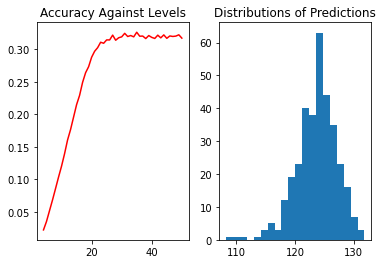

In [60]:
predict_features = pd.read_csv('prediction_X.csv')

predict_features['DATE'] = pd.to_datetime(predict_features['DATE'])
predict_features['day of year'] = predict_features['DATE'].dt.dayofyear

predict_features = predict_features[['day of year', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']]
predict_features.dropna(inplace=True)
print(predict_features.isna().sum())

model.fit(X_train, y_train.values.ravel())
predictions = model.predict(predict_features)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title('Accuracy Against Levels')
ax1.plot(levels, accuracy, c='red')
ax2.hist(predictions, bins=20)
ax2.set_title('Distributions of Predictions')

print(np.mean(predictions))
print(np.quantile(predictions, [0.25, 0.5, 0.75]))
